In [2]:
import numpy as np
from scipy.linalg import block_diag
import scipy.spatial.distance as distance
import scipy.spatial as spatial
import scipy.stats as stats
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import networkx as nx
import sklearn.manifold
import seaborn as sns
import os
import warnings
import matplotlib.patches as patches

In [3]:
def rectangle_mesh(dims):
    """
    Rectangular mesh adjacency matrix and positions.
    Args:
        dims: tuple containing dimensions of graph
    Returns:
        adj: adjacency matrix
        pos: positions of each node in Rn where n = len(dims)
        labels: all zero (shape (n,))
    """
    mesh = np.meshgrid(*[np.arange(d) for d in dims])
    xy = np.stack(mesh).reshape(len(dims), -1).T

    dist_mat = distance.squareform(distance.pdist(xy, "euclidean"))
    adj = np.array(dist_mat <= 1., dtype=np.float32)
    adj = adj - np.diag(np.diag(adj))
    return adj, xy, np.zeros(len(adj))

In [4]:
def four_rooms(dims, doorway=1.):
    """
    Args:
      dims: [dimx, dimy] dimensions of rectangle
      doorway: size of doorway
    Returns:
      adjmat: adjacency matrix
      xy: xy coordinates of each state for plotting
      labels: empty []
    """
    half_x, half_y = (dims[0]*.5, dims[1]*.5)
    quarter_x, quarter_y = (dims[0]*.25, dims[1]*.25)
    threequarter_x, threequarter_y = (dims[0]*.75, dims[1]*.75)

    adj, xy, _ = rectangle_mesh(dims)
    room = np.array([xy[:,0] < half_x, xy[:,1] < half_y], dtype=np.float32).T
    mask = np.array(distance.squareform(distance.pdist(room, "euclidean")) == 0, dtype=np.float32)
    labels = np.sum(room * np.array([[1, 2]]), 1)

    doorsx = [quarter_x, threequarter_x, half_x, half_x]
    doorsy = [half_y, half_y, quarter_y, threequarter_y]
    doors = np.array([doorsx, doorsy]).T
    inds = []
    for d in doors:
        dist_to_door = np.sum(np.abs(xy - d[None, :]), 1)
        ind = np.where(dist_to_door == np.min(dist_to_door))[0]
        if len(ind) > 1: ind = ind[0]
        mask[ind, :] = 1
        mask[:, ind] = 1

    adj = adj * mask
    return adj, xy, labels

In [5]:
dims_fourrooms = [20,20]
adj, xy, labels= four_rooms(dims_fourrooms)

In [6]:
def plot_graph(adj, ax=None, xy=None, show_ticks=False,
               node_size=300, node_color=None, cmap=None, vmin=None, vmax=None,
               show_node_labels=False, skip_edges=False, atol=1e-7):
    graph = nx.from_numpy_array(adj)
    if xy is None:
        xy = nx.spring_layout(graph)

    if node_color is None:
        node_color = np.zeros((len(adj), 3))

  # if node_color variation is likely numerical error, replace with mean
    if node_color.max() - node_color.min() < atol:
        node_color = node_color * 0 + node_color.mean()

    if (vmin is None) and (vmax is None):
        vmax = np.max(np.abs(node_color))
    if np.min(node_color) < 0:
        vmin = -1 * vmax
    if cmap is None:
        cmap = "RdBu"
    else:
        vmin = np.min(node_color)

    if ax is None:
        _, ax = plt.subplots(1)

    nodes = nx.draw_networkx_nodes(graph, pos=xy, node_size=node_size,
                                 node_color=node_color, cmap=cmap, vmin=vmin,
                                 vmax=vmax, ax=ax)

    nodes.set_edgecolor("k")
  # Suppressing networkx deprecation error (...you probably shouldn't really do this)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    if not skip_edges:
        nx.draw_networkx_edges(graph, pos=xy, ax=ax)
    if show_node_labels:
        nx.draw_networkx_labels(graph, pos=xy)
    if not show_ticks:
        ax.set_xticks([])
        ax.set_yticks([])


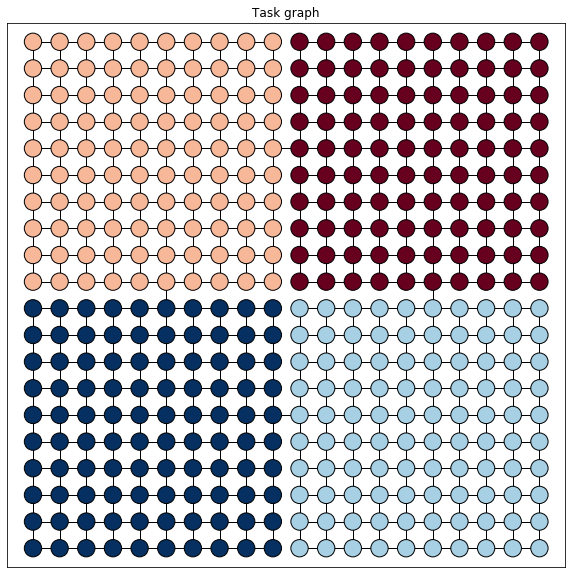

In [7]:
# Visualize task graph.
def visualize_task_graph(adj, xy, labels, node_size=100):
    _, ax = plt.subplots(1, figsize=(10, 10))
    plot_graph(adj, xy=xy, ax=ax, node_color=labels, node_size=node_size)
    _ = ax.axis("equal")
    _ = ax.set_title("Task graph")
    
visualize_task_graph(adj, xy, labels, node_size=300)

In [8]:
def successor_rep(transmat, discount):
    """
      Compute successor representation matrix analytically, using the following.
      M = sum_(t=0)^infinity (discount^t T^t) = (I - discount*T)^(-1)  (eq. 7)
      Args:
        transmat: [n_state x n_state] transition matrix, where transmat[i, j] is
            equal to the probability of transitioning from state i from state j
        discount: scalar discount factor between [0 inclusive, 1 exclusive)
      Returns:
        srmat: successor representation matrix M, where srmat[i, j] is equal to the
            expected discounted number of visitations to state j starting from state
            i (eq. 3)
        scores (all zeros, shape (n,))
    """
    transmat = np.array(transmat, dtype=np.float32)
    n_state = transmat.shape[0]
    srmat = np.linalg.inv(np.eye(n_state) - discount * transmat)
    return srmat, np.zeros(len(srmat))

def l1_normalize_rows(mat):
    """
    Normalize non-zero rows of mat so that they sum to 1.

    Args:
        mat: matrix to normalize

    Returns:
        l1normmat: matrix with rows that sum to 1 or 0.
    """
    denom = np.sum(mat, axis=1)
    denom[denom == 0] = 1.
    l1normmat = np.divide(mat.T, denom).T
    return l1normmat

In [9]:
sr_discount = .9
randomwalk_transmat = l1_normalize_rows(adj)
rep_features, _ = successor_rep(randomwalk_transmat, sr_discount)

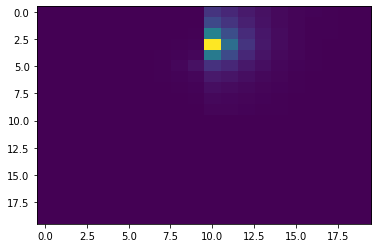

In [10]:
sr_cell = np.reshape(rep_features[:,70],(20,20))
plt.imshow(sr_cell, aspect='auto', interpolation='none')

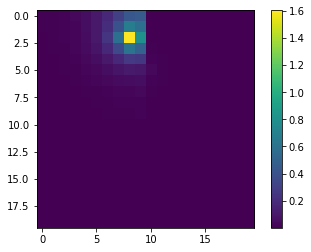

In [30]:
sr_cell = np.reshape(rep_features[:,48],(20,20))
plt.imshow(sr_cell, aspect='auto', interpolation='none')
plt.gca().set_aspect('equal')
plt.colorbar()

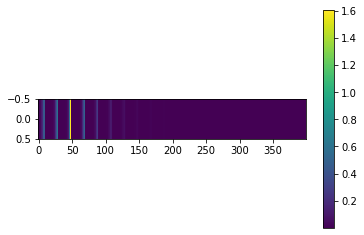

In [16]:
plt.imshow(np.reshape(rep_features[:,48],(1,400)), aspect='60', interpolation='none')
plt.colorbar()

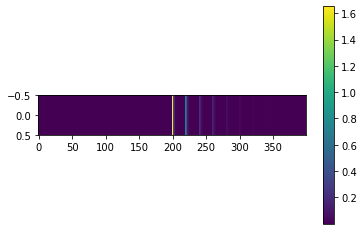

In [29]:
plt.imshow(np.reshape(rep_features[:,200],(1,400)), aspect='60', interpolation='none')
plt.colorbar()

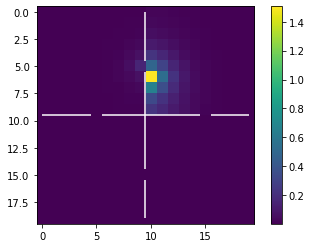

In [22]:
sr_cell = np.reshape(rep_features[:,130],(20,20))
dims = dims_fourrooms
half_x, half_y = (dims[0]*.5-0.5, dims[1]*.5-0.5)
quarter_x, quarter_y = (dims[0]*.25-0.5, dims[1]*.25-0.5)
threequarter_x, threequarter_y = (dims[0]*.75-0.5, dims[1]*.75-0.5)
plt.imshow(sr_cell, aspect='auto', interpolation='none')
plt.vlines(x = half_x, ymin = 0, ymax = quarter_y, colors = 'white') 
plt.vlines(x = half_x, ymin = quarter_y+1, ymax = threequarter_y, colors = 'white') 
plt.vlines(x = half_x, ymin = threequarter_y+1, ymax = dims[1]-1, colors = 'white') 
plt.hlines(y = half_y, xmin = 0, xmax = quarter_x, colors = 'white') 
plt.hlines(y = half_y, xmin = quarter_x+1, xmax = threequarter_x, colors = 'white') 
plt.hlines(y = half_y, xmin = threequarter_x+1, xmax = dims[0]-1, colors = 'white') 
plt.gca().set_aspect('equal')
plt.colorbar()

In [24]:
def euclidean_gaussian(xy, sigma, centers=None, ncenters=None):
    """
    Return position in terms of Euclidean Gaussian RBFs.

    Args:
        xy: nstate x 2 array of xy positions
        sigma: sigma for Gaussian
        centers: locations of the Gaussian centers (if None, draw random or
            use xy)
        ncenters: if centers not supplied, use as number of Gaussian centers
            (if None, use xy as centers)

    Returns:
        State representations as Gaussian RBFs
        scores (all zeros, shape (n,))
    """
    if centers is None:
        if ncenters is None:
            centers = xy
        else:
            centers = np.random.rand(ncenters, 2)
            centers = centers * (xy.max(0) - xy.min(0)) + xy.min(0)

    rep = []
    for center in centers:
        rep.append(stats.multivariate_normal.pdf(xy, mean=center, cov=sigma))
    return np.array(rep).T, centers

In [25]:
sigma_gaussian = 1.
n_gaussian_centers = 100
place_cells, centers = euclidean_gaussian(xy, sigma_gaussian, None, n_gaussian_centers)

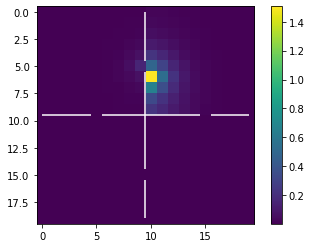

In [26]:
pl_cell = np.reshape(place_cells[:,17],(20,20))
dims = dims_fourrooms
half_x, half_y = (dims[0]*.5-0.5, dims[1]*.5-0.5)
quarter_x, quarter_y = (dims[0]*.25-0.5, dims[1]*.25-0.5)
threequarter_x, threequarter_y = (dims[0]*.75-0.5, dims[1]*.75-0.5)
plt.imshow(sr_cell, aspect='auto', interpolation='none')
plt.vlines(x = half_x, ymin = 0, ymax = quarter_y, colors = 'white') 
plt.vlines(x = half_x, ymin = quarter_y+1, ymax = threequarter_y, colors = 'white') 
plt.vlines(x = half_x, ymin = threequarter_y+1, ymax = dims[1]-1, colors = 'white') 
plt.hlines(y = half_y, xmin = 0, xmax = quarter_x, colors = 'white') 
plt.hlines(y = half_y, xmin = quarter_x+1, xmax = threequarter_x, colors = 'white') 
plt.hlines(y = half_y, xmin = threequarter_x+1, xmax = dims[0]-1, colors = 'white') 
plt.gca().set_aspect('equal')
plt.colorbar()

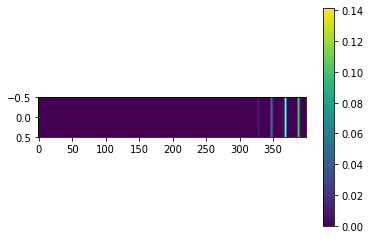

In [28]:
plt.imshow(np.reshape(place_cells[:,99],(1,400)), aspect='60', interpolation='none')
plt.colorbar()